# Tracknet Court Approach

In this notebook the TrackNet architecture is leveraged for court keypoint detection.

Test results are generated

### imports

In [1]:
from torch.utils.data import Dataset
from court_dataset import CourtDataset
from court_dataset_heatmaps import CourtDatasetHeatmap
from torch.utils.data import DataLoader
from CourtTrackNet import Court_TN
import torch.nn as nn
import torchvision.models as models
import torch
import torch.optim as optim
from tqdm import tqdm
from torchvision.transforms import functional as F
import matplotlib.pyplot as plt
import time
import numpy as np
import random
import matplotlib.pyplot as plt
import os
import cv2
import pandas as pd

## Functions

In [2]:
def create_dataloader(dataset, batch_size=32, shuffle=True, num_workers=4):
    return DataLoader(
        dataset, 
        batch_size=batch_size, 
        shuffle=shuffle, 
        num_workers=num_workers, 
        pin_memory=True
    )

In [3]:
class WeightedBCELoss(nn.Module):
    def __init__(self):
        super(WeightedBCELoss, self).__init__()

    def forward(self, predictions, targets):
        # Calculate weights based on predictions
        weights = predictions

        # Compute the two terms of WBCE
        term1 = (1 - weights) ** 2 * targets * torch.log(predictions + 1e-8)
        term2 = weights ** 2 * (1 - targets) * torch.log(1 - predictions + 1e-8)

        # Compute the total loss
        loss = -torch.sum(term1 + term2) 
        return loss

In [4]:
def create_TrackNet_CourtModel(num_coordinates=15):
    model = Court_TN(output_size=num_coordinates)
    return model

In [5]:
def train(model, train_loader, optimizer, device, epoch, criterion=torch.nn.MSELoss()):
    model.train()
    start_time = time.time()
    total_loss = 0
    num_batches = 0

    with tqdm(train_loader, desc=f"Epoch {epoch}", unit="batch") as pbar:
        for batch_idx, (images, heatmaps_gt, points, idx) in enumerate(train_loader):
            images = images.to(device)
            heatmaps_gt = heatmaps_gt.to(device)

            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)

            # Compute loss
            loss = criterion(outputs, heatmaps_gt)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Accumulate loss
            total_loss += loss.item()
            num_batches += 1

            # Update progress bar
            duration = time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time))
            pbar.set_postfix({'loss': loss.item(), 'time': duration})
            pbar.update(1)

    avg_loss = total_loss / num_batches
    return avg_loss


def calculate_position(output, threshold_probability=0.5):
    # Convert to binary map based on the threshold
    binary_map = (output > threshold_probability).astype(np.uint8)

    # Perform connected component analysis
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary_map, connectivity=8)

    if num_labels > 1:  # Exclude the background label (label 0)
        # Find the largest connected component (excluding background)
        largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])  # Offset by 1 due to excluding background
        largest_centroid = centroids[largest_label]
        return int(largest_centroid[0]), int(largest_centroid[1])
    else:
        # No connected component found
        return -1, -1

def compute_mse(points, positions, img_size=(1280, 720)):
    # check that len is the same
    assert len(points) == len(positions) 
    
    #loop over points
    mse = []
    max_distance = img_size[0]**2 + img_size[1]**2
    for i in range(len(points)):
        # get the point
        point = points[i]
        # get the position
        position = positions[i]

        # if the point is outside the image, skip
        if point[0] < 0 or point[0] >= img_size[0] or point[1] < 0 or point[1] >= img_size[1]:
            continue

        # if the position is -1,-1 return the maximum distance
        if position[0] == -1 and position[1] == -1:
            continue
        
        # calculate the distance
        distance = np.linalg.norm(np.array(point) - np.array(position))

        # add to mse
        mse.append(distance**2)

    # Handle case where no valid points exist
    if not mse:
        return max_distance  # Return maximum penalty for missing data

    # return the mean
    return np.mean(mse)


def compute_counts(points, positions, img_size=(1280, 720), threshold=4):
    # check that len is the same
    assert len(points) == len(positions) 
    
    #loop over points
    tp = 0
    fp = 0
    fn = 0
    tn = 0

    for i in range(len(points)):
        # get the point
        point = points[i]
        # get the position
        position = positions[i]

        # if the point is outside the image
        if point[0] < 0 or point[0] >= img_size[0] or point[1] < 0 or point[1] >= img_size[1]:
            # if the position is -1,-1 its tn
            if position[0] == -1 and position[1] == -1:
                tn += 1
            # false positive if model predicted something
            else:
                fp+= 1

        # if the position is -1,-1 FN
        elif position[0] == -1 and position[1] == -1:
            fn += 1
            continue
        
        # calculate the distance
        distance = np.linalg.norm(np.array(point) - np.array(position))

        # add to tp, fp, fn, tn
        if distance <= threshold:
            tp += 1
        else:
            fp += 1

    # return the metrics
    return tp, fp, tn, fn


def calculate_metrics(tp, fp, tn, fn):
    # Avoid division by zero for precision and recall
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0

    # F1-score calculation
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0

    # Accuracy calculation
    total = tp + fp + tn + fn
    accuracy = (tp + tn) / total if total > 0 else 0.0

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }
    

def validate(model, val_loader, device, criterion=torch.nn.MSELoss(), threshold=4, img_size=(1280, 720)):
    model.eval()  # Set the model to evaluation mode
    tp, fp, tn, fn = 0, 0, 0, 0  # Initialize counts
    losses = []
    mse_scores = []

    with tqdm(total=len(val_loader), desc="Validation", unit="batch") as pbar:
        for batch_idx, batch in enumerate(val_loader):
            with torch.no_grad():
                # Prepare data
                inputs = batch[0].float().to(device)  # Input images
                heatmaps_gt = batch[1].float().to(device)  # Ground truth heatmaps
                points = batch[2].float().cpu().numpy()  # Ground truth keypoints (Numpy array)

                # Forward pass
                outputs = model(inputs).to(device)  # Predicted heatmaps (Batch, Keypoints, Height, Width)

                # Compute loss
                loss = criterion(outputs, heatmaps_gt)  # MSE between predicted and ground truth heatmaps
                losses.append(loss.item())

                # First loop: Iterate over each item in the batch
                for i in range(outputs.shape[0]):  # Loop over batch samples
                    positions = [] 

                    # Second loop: Iterate over each keypoint in the current sample
                    for j in range(outputs.shape[1]):  # Loop over keypoints
                        heatmap = outputs[i][j]  # Extract heatmap for the current keypoint
                        position = calculate_position(heatmap.cpu().numpy(), threshold_probability=0.5)  # Compute position
                        positions.append(position)  # Append position for this keypoint

                    #Compute MSE for the batch
                    mse = compute_mse(points[i], positions, img_size)
                    mse_scores.append(mse)

                    # Compute TP, FP, TN, FN for the batch
                    item_tp, item_fp, item_tn, item_fn = compute_counts(points[i], positions, img_size, threshold)
                    tp += item_tp
                    fp += item_fp
                    tn += item_tn
                    fn += item_fn

                # Update the tqdm bar
                pbar.set_postfix({
                    'loss': round(np.mean(losses), 6)
                })
                pbar.update(1)

    # Calculate overall metrics
    mean_loss = np.mean(losses)
    mean_mse = np.mean(mse_scores)
    metrics = calculate_metrics(tp, fp, tn, fn)

    return mean_loss, mean_mse, metrics


In [6]:
# Seed for reproducibility
SEED = 42

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

def setup_paths(exp_id):
    exps_path = f'./exps/{exp_id}'
    if not os.path.exists(exps_path):
        os.makedirs(exps_path)
    
    paths = {
        "model_last": os.path.join(exps_path, 'model_last.pth'),
        "model_best": os.path.join(exps_path, 'model_best.pth'),
        "log": os.path.join(exps_path, 'training_log.txt')
    }
    return paths

In [7]:
def create_dataloaders(dataset_path, batch_size):
    train_dataset = CourtDatasetHeatmap(
        path=dataset_path,
        split="train",
        input_height=720,
        input_width=1280,
        model_height=288,
        model_width=512,
        augment=True,
        selected_points=None
    )
    
    val_dataset = CourtDatasetHeatmap(
        path=dataset_path,
        split="validation",
        input_height=720,
        input_width=1280,
        model_height=288,
        model_width=512,
        augment=False,
        selected_points=None
    )
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

    return train_loader, val_loader

In [ ]:
def training():
    set_seed(SEED)
    best_val_loss = float("inf")
    no_improvement_steps = 0  
    val_intervals = 2
    selected_gpus = [0,1]
    patience = 6 
    dataset_path = "../../00_Dataset"
    batch_size = 32
    num_coordinates = 15  # Number of keypoints
    num_epochs = 100
    learning_rate = 0.1
    loss_fn = WeightedBCELoss()
    
    #create name based aon augment, input and output number
    exp_id = "CourtTrackNet_test"
    
    # Set up paths for experiment and logging
    paths = setup_paths(exp_id)

    # Device setup
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Start logging to a file
    with open(paths["log"], 'w') as log_file:
        log_file.write("Epoch,Train_Loss,Val_Loss,MSE,Accuracy,F1\n")

        # Create data loaders
        train_loader, val_loader = create_dataloaders(dataset_path, batch_size)

        # Model setup
        model = Court_TN(output_size=num_coordinates)
        model = nn.DataParallel(model, device_ids=selected_gpus)
        model = model.to(f'cuda:{selected_gpus[0]}')
        
        # Loss function and optimizer
        criterion = loss_fn
        optimizer = optim.Adadelta(model.parameters(), lr=learning_rate)

        # Learning rate scheduler
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', factor=0.1, patience=3
        )

        # Set the primary device (first GPU in the list)
        device = torch.device(f'cuda:{selected_gpus[0]}')
        
        # train epochs
        for epoch in range(1, num_epochs + 1):
            # set epoch seed
            set_seed(SEED + epoch)
            
            # Training step
            train_loss = train(model, train_loader, optimizer, device, epoch, criterion=criterion)
            log_file.write(f"{epoch},{train_loss}")

            # Validation step
            if epoch > 0 and epoch % val_intervals == 0:
                val_loss, mean_mse, metrics = validate(model, val_loader, device, criterion=criterion)
                log_file.write(f",{val_loss},{mean_mse},{metrics['accuracy']},{metrics['f1']}\n")

                # Step the scheduler based on validation loss
                scheduler.step(val_loss)

                # Save the best model
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    no_improvement_steps = 0  # Reset counter
                    #save model
                    torch.save(model.module.state_dict(), paths["model_best"])
                else:
                    no_improvement_steps += 1  # Increment counter

                # Early stopping check
                if no_improvement_steps >= patience:
                    print("Early stopping triggered. No improvement in validation for", patience, "validation steps.")
                    break
            else:
                log_file.write("\n")  # Log training loss only if no validation

            # Save the latest model checkpoint
            torch.save(model.module.state_dict(), paths["model_last"])

        return paths["model_best"]

def load_model(best_model_path):
    selected_gpus = [0, 1]
    device = torch.device(f'cuda:{selected_gpus[0]}' if torch.cuda.is_available() else 'cpu')

    # Recreate the model architecture
    model = Court_TN(input_size=1, output_size=15)
    model.load_state_dict(torch.load(best_model_path, map_location=device))  # Load weights
    model = model.to(device)  # Move the model to the specified device
    model.eval()  # Set the model to evaluation mode

    print(f"Model loaded from: {best_model_path}")
    return model

## Train Model

In [9]:
best_model_path = training()
model = load_model(best_model_path)

Samples: 1042
Samples: 177


Validation: 100%|██████████| 6/6 [00:03<00:00,  1.85batch/s, loss=3.52e+3]

Early stopping triggered. No improvement in validation for 6 validation steps.
Model loaded from: ./exps/CourtTrackNet_test/model_best.pth



/tmp/ipykernel_229115/3932563848.py:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path, map_location=device))  # Load weight

## Visualize results

In [10]:
def plot_random_val_image_with_heatmaps(model, val_loader, device, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()  # Set the model to evaluation mode

    # Select a random batch from the DataLoader
    random_batch_idx = random.randint(0, len(val_loader) - 1)
    for i, batch in enumerate(val_loader):
        if i == random_batch_idx:
            inputs, heatmaps_gt, points = batch[0], batch[1], batch[2]
            break

    # Select a random sample from the batch
    idx = random.randint(0, inputs.size(0) - 1)
    input_image = inputs[idx].to(device).unsqueeze(0)  # Select image, add batch dimension
    ground_truth_heatmaps = heatmaps_gt[idx].cpu().numpy()  # Ground truth heatmaps
    points = points[idx].cpu().numpy()
    positions = []

    # Perform prediction
    with torch.no_grad():
        predicted_heatmaps = model(input_image).squeeze(0).cpu().numpy()  # Predicted heatmaps

    positions = []
    
        # Calculate positions from predicted heatmaps
    for heatmap in predicted_heatmaps:
        position = calculate_position(heatmap, 0.5)
        positions.append(position)
        
    img_size = (1280,720)
    # Compute MSE for this batch
    mse = compute_mse(points, positions, img_size)

    # Compute TP, FP, TN, FN for this batch
    tp, fp, tn, fn = compute_counts(points, positions, img_size, 5)

    print(mse)
    print(calculate_metrics(tp, fp, tn, fn))

    # Convert the image for visualization
    img = inputs[idx].permute(1, 2, 0).cpu().numpy()  # Convert (C, H, W) to (H, W, C)

    # De-normalize the image
    img = img * std + mean  # Reverse normalization
    img = np.clip(img, 0, 1)  # Ensure pixel values are in range [0, 1]
    img = (img * 255).astype("uint8")  # Convert to [0, 255] range for visualization

    # Plot the image and heatmaps
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    # Original image with overlaid predicted heatmaps and points
    axs[0].imshow(img)
    combined_heatmap = np.sum(predicted_heatmaps, axis=0)  # Combine all heatmaps
    axs[0].imshow(combined_heatmap, cmap="hot", alpha=0.5)  # Overlay heatmap
    axs[0].set_title("Image with Predicted Heatmap Overlay")

    # Plot ground truth points (green) with indices
    for i, point in enumerate(points):
        axs[0].scatter(point[0], point[1], c='green', s=40, label="GT Points" if 'GT Points' not in axs[0].get_legend_handles_labels()[1] else "")
        axs[0].text(point[0], point[1], str(i), color='green', fontsize=8)  # Add index as text

    # Plot predicted positions (red) with indices
    for i, pos in enumerate(positions):
        if pos != (-1, -1):  # Skip invalid positions
            axs[0].scatter(pos[0], pos[1], c='red', s=40, label="Predicted Points" if 'Predicted Points' not in axs[0].get_legend_handles_labels()[1] else "")
            axs[0].text(pos[0], pos[1], str(i), color='red', fontsize=8)  # Add index as text

    axs[0].legend()
    axs[0].axis("off")

    # Plot combined heatmap
    axs[1].imshow(combined_heatmap, cmap="hot")
    axs[1].set_title("Combined Predicted Heatmaps")
    axs[1].axis("off")

    plt.tight_layout()
    plt.show()

In [11]:
# Set the primary device (first GPU in the list)
train_loader, val_loader = create_dataloaders("../FinalDataset", 32)
selected_gpus = [0,1]
device = torch.device(f'cuda:{selected_gpus[0]}')

Samples: 1042
Samples: 177


5.012366409569707
{'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1': 1.0}


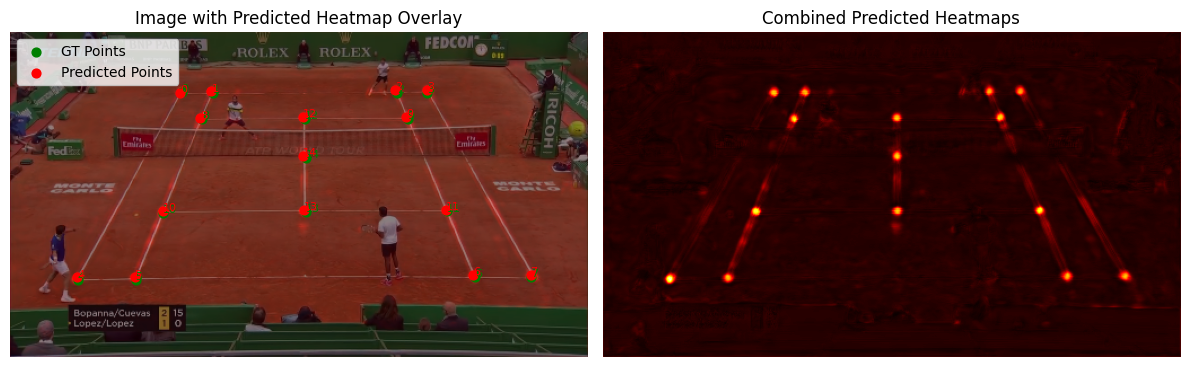

In [12]:
plot_random_val_image_with_heatmaps(model, val_loader, device)

## test evaluation

In [ ]:
test_dataset = CourtDatasetHeatmap(
        path="../../00_Dataset",
        split="test",
        input_height=720,
        input_width=1280,
        model_height=288,
        model_width=512,
        augment=False,
        selected_points=None
    )
    
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

Samples: 199


In [14]:
def validate_test(model, val_loader, device, dataset, criterion=torch.nn.MSELoss(), threshold=4, img_size=(1280, 720)):
    model.eval()  # Set the model to evaluation mode
    tp, fp, tn, fn = 0, 0, 0, 0  # Initialize counts
    losses = []
    mse_scores = []
    predictions = []

    with tqdm(total=len(val_loader), desc="Validation", unit="batch") as pbar:
        for batch_idx, batch in enumerate(val_loader):
            with torch.no_grad():
                # Prepare data
                inputs = batch[0].float().to(device)  # Input images
                heatmaps_gt = batch[1].float().to(device)  # Ground truth heatmaps
                points = batch[2].float().cpu().numpy()  # Ground truth keypoints (Numpy array)
                idx = batch[3].cpu().numpy()  # Sample indices

                # Forward pass
                outputs = model(inputs).to(device)  # Predicted heatmaps (Batch, Keypoints, Height, Width)

                # Compute loss
                loss = criterion(outputs, heatmaps_gt)  # MSE between predicted and ground truth heatmaps
                losses.append(loss.item())

                # First loop: Iterate over each item in the batch
                for i in range(outputs.shape[0]):  # Loop over batch samples
                    positions = [] 

                    # Second loop: Iterate over each keypoint in the current sample
                    for j in range(outputs.shape[1]):  # Loop over keypoints
                        heatmap = outputs[i][j]  # Extract heatmap for the current keypoint
                        position = calculate_position(heatmap.cpu().numpy(), threshold_probability=0.5)  # Compute position
                        positions.append(position)  # Append position for this keypoint

                    # get entry from dataset
                    entry = dataset.data.iloc[idx[i]].to_dict()

                    #Compute MSE for the batch
                    mse = compute_mse(points[i], positions, img_size)
                    mse_scores.append(mse)

                    # add predictions with entry
                    predictions.append({
                        "idx": idx[i],
                        "points_transformed": points[i],
                        "positions": positions,
                        "mse":mse,
                        **entry})

                    # Compute TP, FP, TN, FN for the batch
                    item_tp, item_fp, item_tn, item_fn = compute_counts(points[i], positions, img_size, threshold)
                    tp += item_tp
                    fp += item_fp
                    tn += item_tn
                    fn += item_fn

                # Update the tqdm bar
                pbar.set_postfix({
                    'loss': round(np.mean(losses), 6)
                })
                pbar.update(1)

    # Calculate overall metrics
    mean_loss = np.mean(losses)
    mean_mse = np.mean(mse_scores)
    metrics = calculate_metrics(tp, fp, tn, fn)

    #convert predictions to dataframe
    predictions_df = pd.DataFrame(predictions)

    return mean_loss, mean_mse, metrics, predictions_df

In [15]:
val_loss, mean_mse, metrics, results = validate_test(model, test_loader, device, test_dataset, criterion=WeightedBCELoss())

Validation: 100%|██████████| 7/7 [00:04<00:00,  1.55batch/s, loss=3.25e+3]


In [16]:
print(val_loss)
print(mean_mse)
print(metrics)

3253.0945870535716
7.9122141714549
{'accuracy': 0.9730359520639148, 'precision': 0.9857433808553971, 'recall': 0.9867482161060143, 'f1': 0.9862455425369333}


In [17]:
results.head()

,idx,points_transformed,positions,mse,subset,video,clip,frame,points
0,0,"[[179.2, 179.2], [197.6, 178.40001], [300.0, 1...","[(178, 179), (198, 178), (297, 173), (316, 172...",3.185065,New,Video_1,clip_6,250,"{'top_left_corner': [448, 448], 'top_left_sing..."
1,1,"[[179.2, 179.2], [197.6, 178.40001], [300.0, 1...","[(178, 179), (198, 178), (298, 173), (316, 172...",2.699644,New,Video_1,clip_6,300,"{'top_left_corner': [448, 448], 'top_left_sing..."
2,2,"[[179.2, 179.2], [197.6, 178.40001], [300.0, 1...","[(177, 179), (198, 178), (297, 172), (316, 172...",3.232974,New,Video_1,clip_6,350,"{'top_left_corner': [448, 448], 'top_left_sing..."
3,3,"[[197.6, 81.6], [208.8, 81.6], [273.6, 80.4], ...","[(196, 81), (209, 81), (271, 80), (284, 80), (...",2.463234,New,Video_2,clip_7,300,"{'top_left_corner': [494, 204], 'top_left_sing..."
4,4,"[[197.6, 81.6], [208.8, 81.6], [273.6, 80.4], ...","[(196, 81), (209, 81), (272, 80), (284, 79), (...",2.443347,New,Video_2,clip_7,350,"{'top_left_corner': [494, 204], 'top_left_sing..."


In [18]:
results.to_csv("TN_test_results.csv")